In [1]:
from typing import List, Optional

import numpy as np
from observations import mnist

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import tensorflow as tf
import gpflux
import gpflow

In [2]:
(Xall, Yall), (Xs, Ys) = mnist("./data")
Xall /= 255.

>> Downloading ./data/train-images-idx3-ubyte.gz.part 
>> [9.5 MB/9.5 MB] 105% @10.9 MB/s,[0s remaining, 0s elapsed]        
URL https://storage.googleapis.com/cvdf-datasets/mnist/train-images-idx3-ubyte.gz downloaded to ./data/train-images-idx3-ubyte.gz 
>> Downloading ./data/train-labels-idx1-ubyte.gz.part 
>> [28.2 KB/28.2 KB] 3630% @9.2 MB/s,[0s remaining, 0s elapsed]        
URL https://storage.googleapis.com/cvdf-datasets/mnist/train-labels-idx1-ubyte.gz downloaded to ./data/train-labels-idx1-ubyte.gz 
>> Downloading ./data/t10k-images-idx3-ubyte.gz.part 
>> [1.6 MB/1.6 MB] 127% @4.7 MB/s,[0s remaining, 0s elapsed]        
URL https://storage.googleapis.com/cvdf-datasets/mnist/t10k-images-idx3-ubyte.gz downloaded to ./data/t10k-images-idx3-ubyte.gz 
>> Downloading ./data/t10k-labels-idx1-ubyte.gz.part 
>> [4.4 KB/4.4 KB] 23086% @9.0 MB/s,[0s remaining, 0s elapsed]        
URL https://storage.googleapis.com/cvdf-datasets/mnist/t10k-labels-idx1-ubyte.gz downloaded to ./data/t10k-la

In [3]:
# from gpflow import Param, Parameterized, ParamList, params_as_tensors, settings, transforms
# from gpflux.utils import xavier_weights


class PcaResnetEncoder(gpflux.encoders.RecognitionNetwork):

    def __init__(self,
                 latent_dim: int,
                 mean: np.ndarray,
                 pca_projection_matrix: np.ndarray,
                 network_dims: List[int],
                 activation_func = None,
                 name: Optional[str] = None):
        input_dim = pca_projection_matrix.shape[1]
        super().__init__(latent_dim, input_dim, network_dims, activation_func=activation_func, name=name)
        self.pca_projection_matrix = pca_projection_matrix  # [D x L]
        self.mean = mean
        for w in self.Ws:
            w = w.read_value() / 5.0  # reduce weights

    @gpflow.decors.params_as_tensors
    def __call__(self, Z: tf.Tensor) -> [tf.Tensor, tf.Tensor]:
        Z = tf.matmul(Z - self.mean, self.pca_projection_matrix)  # [N, L]
        m, v = super().__call__(Z)
        return m + Z, v
    
    @gpflow.decors.autoflow((gpflow.settings.float_type, [None, None]))
    def eval(self, X):
        m, v = self.__call__(X)
        return m, tf.nn.softplus(v - 3.)

def init_pca_projection_matrix(X):
    pca = PCA(n_components=2, whiten=True).fit(X)
    return pca.components_.T / np.sqrt(5)  # P x L

In [4]:
n = 1000
X = Xall[:n]
Y = Yall[:n]

In [5]:
A = init_pca_projection_matrix(X)

In [6]:
L = 2
enc = PcaResnetEncoder(L, np.mean(X, axis=0), A, [5, 5])

In [7]:
T = ((X - np.mean(X, axis=0)) @ A)

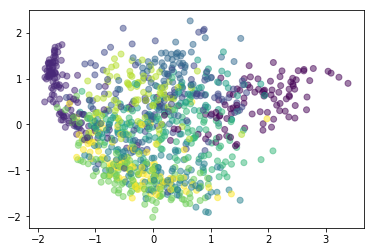

In [8]:
plt.scatter(T[:, 0], T[:, 1], alpha=.5, c=Y)
plt.show()

In [9]:
Tm, Tv = enc.eval(X)

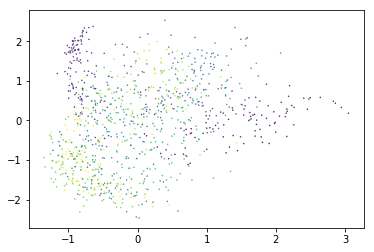

In [12]:
plt.scatter(Tm[:, 0], Tm[:, 1], c=Y, s=np.sqrt(Tv).max(axis=1))
plt.show()

In [14]:
np.sqrt(Tv).max(axis=1).shape

(1000,)